### 비지도 딥러닝 / PCA / Hierarchical Cluster (complete) / CNN 전이 VGG16 
- X 데이터 량 : R&B 9665 곡
- y : 비지도 군집 4 clusters
- 모델 : VGG16

In [28]:
#넘파이 배열 확인과 이미지 생성용
import numpy as np
import matplotlib.pyplot as plt

#폴더의 리스트 모으는데 사용할걳
from tqdm import tqdm_notebook as tq
import os

#스펙트로그램 이미지화
import librosa
import librosa.display

# 프레임 그려주는 라이브러리
import pandas as pd

# 소요 분석
from sklearn.decomposition import PCA

# 비지도 군집 hierarchy - linkage, 시각화 dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
# 클러스터링 한것 라벨링하기
from scipy.cluster.hierarchy import fcluster

# 플롯 시각화  -덴드로그램출력 시에 필요
import matplotlib.pyplot as plt


import glob
import tensorflow as tf

# 모델링시 트레인테스트 셋 분리
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

### 저장할 이미지 탐색

Mel-Spectrogram 문의에 언급된 파라미터
(numbands=48, sampleRate=16000, frameSize=512, hopSize=256, window='hann', weighting='linear', warpingFormula='slaneyMel',normalize='unit_tri' )

In [2]:
# 내가 가지고 있는 멜파일(R&B만) 모양 확인
mel = np.load("01.아레나mel수집,전처리,라벨링,모델링/arena/144008.npy")
mel.shape

(48, 1876)

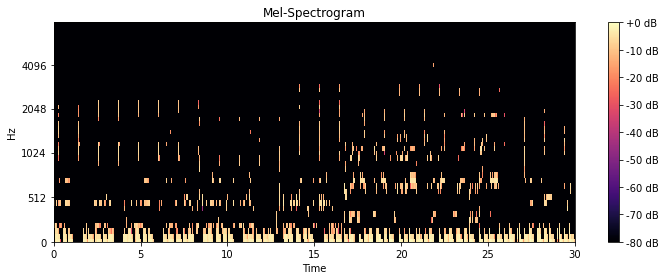

In [3]:
#참고용으로 그려줌
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), y_axis='mel', sr=16000, hop_length=256, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.savefig('Mel-Spectrogram example.png') #png, jpg 둘다 나옴
plt.show()

### 멜 스펙트로그램 이미지 저장
- 저장위치 폴더 : arena_mel_image
- 내가 가지고 멜 파트만 먼저 만들어봄


FileNotFoundError: [Errno 2] No such file or directory: './arena_mel_image/Mel-Spectrogram example.jpg'

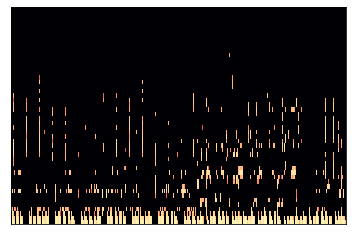

In [4]:
# 범례, 눈금 등 없이 멜 스펙트로그램만 이미지로 저장하는 코드
librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), sr=16000, hop_length=256)
plt.savefig('./arena_mel_image/Mel-Spectrogram example.jpg')
plt.show()

In [ ]:
# 내가 가지고 있는 멜 파일 리스트로 저장
path = 'arena/' # 내 RandB mel 파일들 (npy)경로 
npy_list = os.listdir(path)

num = 1
for i in tq(npy_list):
    mel = np.load("./arena/{}".format(i)) # 파일 하나씩 npy 배열 소환
    librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), sr=16000, hop_length=256)
    plt.savefig("./arena_mel_image/{}".format(num)) # 사전 만들어둔 arena_mel_image 폴더에 이미지 저장
    num = num+1
    
# 이미지 다 모아졌고(갯수일치함),넘파이 쉐입 안맞는 거랑(그래서 이미지크기가다름), 이미지 만들다가 중간 정지된것 찾아서 재 생성 해줘야 함.

# 이미지 불러와 VGG16 모델링 <- 지도 학습
- y 데이터 준비과정 <- 비지도 학습
    - 라벨은 Mel-Spectrogram 을 4개로 축소
    - 데이터 정제 PCA : 한 곡당 48*1876 = 90,048 값 -> 4 개로 축소
    - 비지도 학습법으로 군집사용 Hierarchical - average 4개 군집은 너무 편향됨. complete로 진행
    
- X 데이터 
    - 멜 스팩트럼 이미지

### y  데이터 준비

##### PCA 할 경우 주성분이 몇개에 얼마의 확률로 담길지 탐색
- 4개 정도만 해도 정당함 -> 11 번 경우 2개 여도 충분, 마지막번이면 3~4개 여도 충분함

pca1 Eigenvalues(고유값, 분산관련):
[3.08296375e+05 1.00420078e+04 7.75840479e+03 7.19504004e+03
 6.15853125e+03 4.33956006e+03 3.67257935e+03 3.61696899e+03
 2.98506592e+03 2.85977563e+03 2.44709204e+03 2.23481665e+03
 2.00074756e+03 1.67580737e+03 1.52861890e+03 1.28186731e+03
 1.26254297e+03 1.04971179e+03 9.28974548e+02 9.19927856e+02
 7.85781860e+02 7.05713928e+02 6.22891968e+02 6.00604675e+02
 5.63862671e+02 5.07250153e+02 5.01706085e+02 4.38536987e+02
 3.53561707e+02 3.36399963e+02 3.05599365e+02 2.80908173e+02
 2.51676056e+02 2.45690384e+02 2.07287064e+02 2.03716812e+02
 1.95645782e+02 1.78168640e+02 1.69218338e+02 1.55589203e+02
 1.48261261e+02 1.34853882e+02 1.19019615e+02 1.13940605e+02
 1.12623108e+02 8.58396378e+01 6.44919815e+01 1.75246040e-08]

Variances (Percentage, 각 주성분의 설명된 분산 비율이 기록되 있음):
[8.09935226e+01 2.63816786e+00 2.03823519e+00 1.89023185e+00
 1.61792731e+00 1.14005959e+00 9.64834988e-01 9.50225472e-01
 7.84216166e-01 7.51300752e-01 6.42883360e-01 5.87115824e-01
 5.2

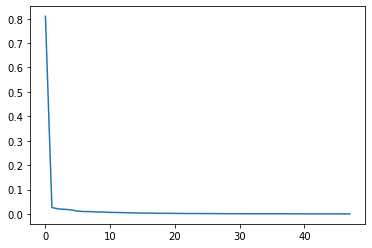

In [6]:
#  멜 한값만(11.npy) 불러와서 요소 개수 얼마가 적당한지 찾아보기
mel1 = np.load('01.아레나mel수집,전처리,라벨링,모델링/arena/11.npy')

##  11.npy 주성분을 48 뽑음!!
pca1 = PCA(n_components=48)
pca1.fit(mel1)
globals()['song_{}'.format(11)] = pca1.singular_values_

print("pca1 Eigenvalues(고유값, 분산관련):")
print(pca1.explained_variance_)

print()
print("Variances (Percentage, 각 주성분의 설명된 분산 비율이 기록되 있음):")
print(pca1.explained_variance_ratio_ * 100)

plt.plot(pca1.explained_variance_ratio_)
plt.show()


pca2 Eigenvalues(고유값, 분산관련):
[308296.4     10042.006    7758.4004   7195.0386]
Variances (Percentage, 각 주성분의 설명된 분산 비율이 기록되 있음):
[80.9935     2.6381664  2.0382333  1.8902309]


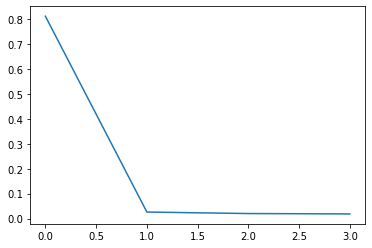

In [7]:
##  11.npy 주성분을 4 뽑음!!
pca2 = PCA(n_components=4)
pca2.fit(mel1)
globals()['song_{}'.format(11)] = pca2.singular_values_
    
print("pca2 Eigenvalues(고유값, 분산관련):")
print(pca2.explained_variance_)
print("Variances (Percentage, 각 주성분의 설명된 분산 비율이 기록되 있음):")
print(pca2.explained_variance_ratio_ * 100)    

plt.plot(pca2.explained_variance_ratio_)
plt.show()

pca1 Eigenvalues(고유값, 분산관련):
[1.1699908e+05 2.4012064e+04 1.5489221e+04 1.1467403e+04 4.9398462e+03
 3.8628091e+03 3.1718447e+03 2.8716067e+03 2.4413279e+03 2.3426497e+03
 1.8789493e+03 1.7256187e+03 1.5929448e+03 1.2699293e+03 1.1766378e+03
 1.0501246e+03 9.4762390e+02 8.4406573e+02 7.8628699e+02 7.4821344e+02
 6.4552295e+02 5.8186658e+02 5.6565015e+02 4.8467795e+02 4.7592307e+02
 4.1746356e+02 3.9925406e+02 3.4435944e+02 3.3076898e+02 2.9682898e+02
 2.7234564e+02 2.2926886e+02 2.2142618e+02 2.0858388e+02 1.9276062e+02
 1.6834601e+02 1.6403387e+02 1.4672174e+02 1.3695680e+02 1.2464272e+02
 1.1545761e+02 1.0920605e+02 9.8319847e+01 8.2912148e+01 7.8252487e+01
 7.5589592e+01 6.3109104e+01 6.6506116e-09]

Variances (Percentage, 각 주성분의 설명된 분산 비율이 기록되 있음):
[5.66174316e+01 1.16197624e+01 7.49544287e+00 5.54923105e+00
 2.39045835e+00 1.86926556e+00 1.53489852e+00 1.38960934e+00
 1.18139148e+00 1.13363981e+00 9.09248948e-01 8.35050166e-01
 7.70847499e-01 6.14535928e-01 5.69390953e-01 5.081695

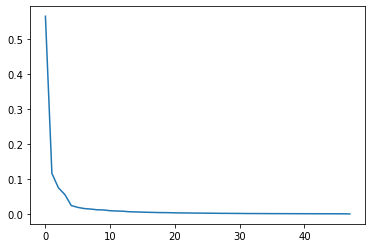

In [8]:
# 다른 곡 마지막곡 (707980.npy)

mel2 = np.load('01.아레나mel수집,전처리,라벨링,모델링/arena/707980.npy')

pca3 = PCA(n_components=48)
pca3.fit(mel2)
globals()['song_{}'.format(11)] = pca1.singular_values_

print("pca1 Eigenvalues(고유값, 분산관련):")
print(pca3.explained_variance_)

print()
print("Variances (Percentage, 각 주성분의 설명된 분산 비율이 기록되 있음):")
print(pca3.explained_variance_ratio_ * 100)

plt.plot(pca3.explained_variance_ratio_)
plt.show()

pca1 Eigenvalues(고유값, 분산관련):
[116999.02   24012.074  15489.224  11467.399]

Variances (Percentage, 각 주성분의 설명된 분산 비율이 기록되 있음):
[56.61741   11.619767   7.4954443  5.549229 ]


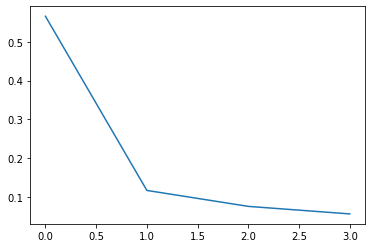

In [9]:
# 다른 곡 마지막곡 (707980.npy)  주성분 4개

pca4 = PCA(n_components=4)
pca4.fit(mel2)
globals()['song_{}'.format(11)] = pca1.singular_values_

print("pca1 Eigenvalues(고유값, 분산관련):")
print(pca4.explained_variance_)

print()
print("Variances (Percentage, 각 주성분의 설명된 분산 비율이 기록되 있음):")
print(pca4.explained_variance_ratio_ * 100)

plt.plot(pca4.explained_variance_ratio_)
plt.show()

In [10]:
# PCA 값으로 정제후 한데이터 프레임으로 담아주기
RandB = pd.read_csv('01.아레나mel수집,전처리,라벨링,모델링/RandB.csv')

id_list = []
for i in range(RandB['id'].size):
    id_list.append(RandB.iloc[i,9])
    
for i in tq(id_list):
    mel = np.load('01.아레나mel수집,전처리,라벨링,모델링/arena/{}.npy'.format(i))
    pca = PCA(n_components=4)
    pca.fit(mel)
    globals()['song_{}'.format(i)] = pca.singular_values_
    
for i in tq(id_list):
    globals()['pca_df_{}'.format(i)] = pd.DataFrame(globals()['song_{}'.format(i)].T)
        
pca_data_fix = pd.DataFrame()
for i in tq(id_list):
    pca_data_fix = pd.concat([pca_data_fix, globals()['pca_df_{}'.format(i)].T], axis=0)
    
idx_arr=[]
for i in range(0,len(id_list)):
    idx_arr.append(id_list[i])
    
pca_data_fix.index=[idx_arr]

pca_data_fix    

#len(pca_data_fix)  47218

<ipython-input-10-a8f20d864092>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tq(id_list):


<ipython-input-10-a8f20d864092>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tq(id_list):


<ipython-input-10-a8f20d864092>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tq(id_list):


,0,1,2,3
11,3806.564209,687.003723,603.858337,581.520935
39,3187.503906,844.196533,705.722168,595.440247
52,4109.362793,764.047729,576.311951,493.919342
57,2819.189697,952.886475,772.690247,604.991028
71,4271.362305,1052.568237,796.845886,596.176636
...,...,...,...,...
707943,3294.496094,1095.628418,761.171326,705.515320
707965,2089.990479,881.120544,547.657410,517.586060
707969,4724.381348,846.011475,617.358948,479.002625
707976,2942.708008,1097.773560,966.961548,796.386780


##### 비지도 클러스터링  Scipy Hierarchical Clustering - complete 설정값
-  average 설정값 : 벨류값이 각각 2-46733, 3-481, 1-3, 4-1  너무 편향되서 complete 사용

In [11]:
clusters = linkage(y=pca_data_fix, method='complete', metric='euclidean')
clusters
#clusters.shape  (47217, 4)

array([[1.12440000e+04, 2.64160000e+04, 0.00000000e+00, 2.00000000e+00],
       [1.85000000e+03, 3.08060000e+04, 6.10351562e-05, 2.00000000e+00],
       [3.13590000e+04, 3.51530000e+04, 6.10351562e-05, 2.00000000e+00],
       ...,
       [9.44240000e+04, 9.44290000e+04, 3.67140665e+03, 2.44000000e+02],
       [9.44300000e+04, 9.44310000e+04, 4.77399502e+03, 4.69740000e+04],
       [9.44320000e+04, 9.44330000e+04, 7.90319451e+03, 4.72180000e+04]])

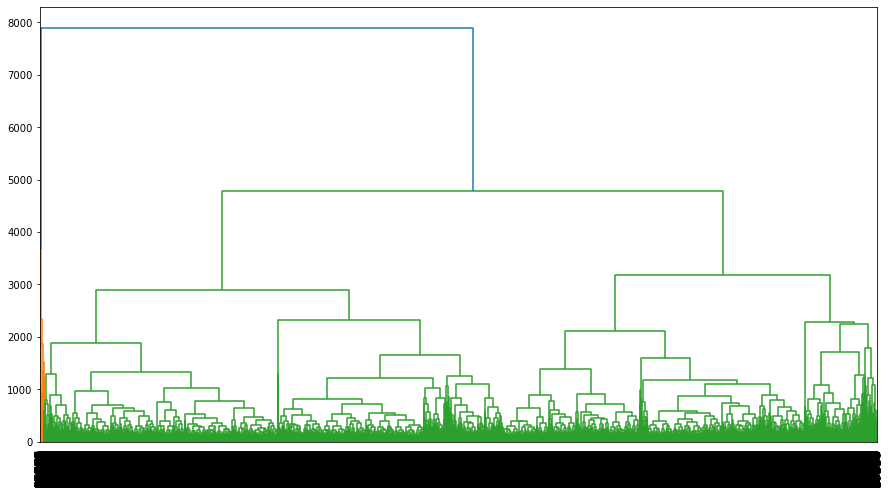

In [12]:
#덴드로그램 시각화 - 시각화 오래 걸림

plt.figure( figsize = (15, 8) )
dendrogram(clusters, leaf_rotation=90, leaf_font_size=12,)
plt.show() 

In [13]:
# 덴드로그램 기준 높에 3,300 으로 군집하여 라벨 달아줌

cut_tree = fcluster(clusters, t=3300, criterion='distance')
cut_tree # prediction

#cut_tree.shape (47218,)

array([4, 3, 4, ..., 4, 3, 3], dtype=int32)

In [14]:
# 각각 몇개씩 클러스터링 되는지 확인

pca_data_fix['cluster'] = cut_tree
pca_data_fix['cluster'].value_counts()

3    25907
4    21067
2      227
1       17
Name: cluster, dtype: int64

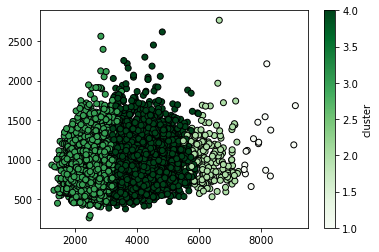

In [15]:
# pca 소요 1번째 것과 2번째 것을 좌표로 시각화

plt.scatter(x=pca_data_fix[0], y=pca_data_fix[1], c=pca_data_fix['cluster'],cmap='Greens',edgecolors='black')
plt.colorbar(label='cluster')
plt.show()

In [16]:
pca_data_fix

,0,1,2,3,cluster
11,3806.564209,687.003723,603.858337,581.520935,4
39,3187.503906,844.196533,705.722168,595.440247,3
52,4109.362793,764.047729,576.311951,493.919342,4
57,2819.189697,952.886475,772.690247,604.991028,3
71,4271.362305,1052.568237,796.845886,596.176636,4
...,...,...,...,...,...
707943,3294.496094,1095.628418,761.171326,705.515320,4
707965,2089.990479,881.120544,547.657410,517.586060,3
707969,4724.381348,846.011475,617.358948,479.002625,4
707976,2942.708008,1097.773560,966.961548,796.386780,3


In [17]:
# cluster 열을 y 값으로 두기 
# 저장한 이미지 사진이 내 이미지 밖에 없어서 위아래로 없는 행은 잘라주기

pd.set_option('display.max_rows',None)
y_reset = pca_data_fix.reset_index()
y_reset1 = y_reset.drop(y_reset[y_reset.level_0 < 144000].index)
y_reset1 = y_reset1.drop(y_reset1[y_reset1.level_0 > 288000].index)
y_reset1

,level_0,0,1,2,3,cluster
9673,144008,2133.922119,905.865723,706.445190,614.249573,3
9674,144020,4171.521973,949.665771,825.389282,549.417297,4
9675,144021,3193.442871,1164.355469,749.181030,697.661011,4
9676,144036,4458.379883,844.930481,629.560669,516.630981,4
9677,144100,3105.054688,804.155945,701.453186,582.508301,3
9678,144127,2465.859863,718.047729,641.832947,593.546204,3
9679,144138,2829.571045,751.848694,690.413208,479.352936,3
9680,144147,3092.113281,893.509033,704.871582,567.661072,3
9681,144150,3951.329102,864.719482,746.070068,604.323303,4
9682,144161,3052.898438,1152.888550,702.085449,595.566895,3


In [19]:
# 라벨로 쓸 데이터 준비

y_reset1 = y_reset1.reset_index()

labels = []

for i in range(len(y_reset1)):
    labels.append(y_reset1['cluster'][i])
len(labels)

#labels 데이터 준비 완료

9665

### X 데이터 준비 
- 이미지 불러와 3차원 데이터 만들기

In [20]:
# 아래 폴더에 9665 개의 파일이 있음

image = glob.glob('/Users/bigdata02/Desktop/2ndProject_202109/arena_mel_image/*.*')

data = []
for i in image:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (67, 100))   
    image=np.array(image)
    data.append(image)

print(len(data))
data[0].shape

9665


(67, 100, 3)

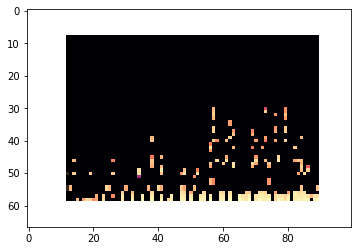

In [21]:
# 다시한번 확인작업 : 이미지 3차원 npy 로 된것 다시 이미지로 그려보기

plt.imshow(data[0])
plt.show()

In [22]:
# 딥러닝 가틍한 형식으로 데이터 변환

X = np.array(data)
y = np.array(labels)
y

array([3, 4, 4, ..., 3, 3, 4], dtype=int32)

In [23]:
y.shape

(9665,)

In [26]:
# Train과 Test 분리 ( 나중에 학습 검증을 위해)

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   test_size=0.3,
                                                   random_state=7) 

# 데이터들의 크기 확인하기
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((6765, 67, 100, 3), (2900, 67, 100, 3), (6765,), (2900,))

In [29]:
# Data Preprocessing 전처리

# Normalize data 정규화
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# One-hot encode target classes 인코딩
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
y_test

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

### VGG-16 Model (CNN 계열 전이학습)
 - X 데이터 : 멜스팩토그램이미지를 np 형태로 변형후 255로 나누어 5차원 정규화
 - y 데이터 : 이미 비지도  Mel-spectrogram-> PCA -> Hieararchical Clustering 하여 1,2,3,4 라벨링을 한 것

In [31]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
#import keras.backend.tensorflow_backend as K
from keras import regularizers
from keras import layers, models
#from keras.applications import VGG16   <- 이거 안되서 아래로 다른 이름으로 넣음
from keras.applications.vgg16 import VGG16
from keras import Input
from keras.models import Model
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
import os
from PIL import Image

from tensorflow.keras import optimizers

In [30]:
# 확장해서 학습 할수도 있어서 일단 가져옴
from tensorflow.keras.models import save_model 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM,Dense, SimpleRNN,Dropout

In [35]:
#vgg16 모델 불러오기 - 모양 확인해줌

#shape 변경해줌
pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(67, 100, 3))
pre_trained_vgg.trainable = False
pre_trained_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 67, 100, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 67, 100, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 67, 100, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 33, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 33, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 33, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 25, 128)       0     

In [40]:
#vgg16 밑에 레이어 추가

additional_model = models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(2048, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
additional_model.add(layers.Dropout(0.5))
additional_model.add(layers.Dense(1024, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
additional_model.add(layers.Dropout(0.5))
additional_model.add(layers.Dense(512, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
additional_model.add(layers.Dropout(0.5))
additional_model.add(layers.Dense(4, activation='softmax'))

additional_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

In [41]:
# 학습, 그리고 이미지 그려주기 위해 history 에 담아줌
# (이미지 픽셀이 크면 학습이 메모리때문에 안되어서 이미지 외부 프로그램으로 픽셀 줄여서 X 데이터 만들고옴)

history = additional_model.fit(X_train, y_train, 
                    batch_size=50, 
                    epochs=100, 
                    validation_data=(X_test, y_test))

Epoch 1/100
136/136 [==============================] - 6s 39ms/step - loss: 122.1285 - acc: 0.5154 - val_loss: 79.3914 - val_acc: 0.5376
Epoch 2/100
136/136 [==============================] - 5s 37ms/step - loss: 50.5163 - acc: 0.5193 - val_loss: 27.5590 - val_acc: 0.4569
Epoch 3/100
136/136 [==============================] - 5s 37ms/step - loss: 17.5616 - acc: 0.5186 - val_loss: 11.2311 - val_acc: 0.5376
Epoch 4/100
136/136 [==============================] - 5s 37ms/step - loss: 8.2409 - acc: 0.5351 - val_loss: 5.8946 - val_acc: 0.5376
Epoch 5/100
136/136 [==============================] - 5s 37ms/step - loss: 4.5126 - acc: 0.5316 - val_loss: 3.4584 - val_acc: 0.5376
Epoch 6/100
136/136 [==============================] - 5s 37ms/step - loss: 2.8677 - acc: 0.5288 - val_loss: 2.4076 - val_acc: 0.5376
Epoch 7/100
136/136 [==============================] - 5s 37ms/step - loss: 2.1325 - acc: 0.5382 - val_loss: 1.9177 - val_acc: 0.5376
Epoch 8/100
136/136 [==============================] - 

Epoch 62/100
136/136 [==============================] - 5s 37ms/step - loss: 1.1633 - acc: 0.5521 - val_loss: 1.1699 - val_acc: 0.5376
Epoch 63/100
136/136 [==============================] - 5s 37ms/step - loss: 1.1636 - acc: 0.5521 - val_loss: 1.1699 - val_acc: 0.5376
Epoch 64/100
136/136 [==============================] - 5s 37ms/step - loss: 1.1628 - acc: 0.5521 - val_loss: 1.1703 - val_acc: 0.5376
Epoch 65/100
136/136 [==============================] - 5s 37ms/step - loss: 1.1631 - acc: 0.5521 - val_loss: 1.1699 - val_acc: 0.5376
Epoch 66/100
136/136 [==============================] - 5s 37ms/step - loss: 1.1638 - acc: 0.5521 - val_loss: 1.1699 - val_acc: 0.5376
Epoch 67/100
136/136 [==============================] - 5s 37ms/step - loss: 1.1630 - acc: 0.5521 - val_loss: 1.1698 - val_acc: 0.5376
Epoch 68/100
136/136 [==============================] - 5s 37ms/step - loss: 1.1633 - acc: 0.5521 - val_loss: 1.1700 - val_acc: 0.5376
Epoch 69/100
136/136 [==============================] -

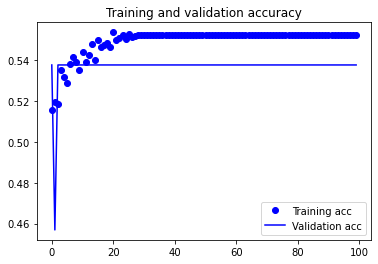

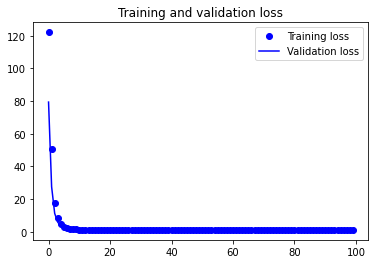

In [43]:
# 정확도 확인 시각화
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

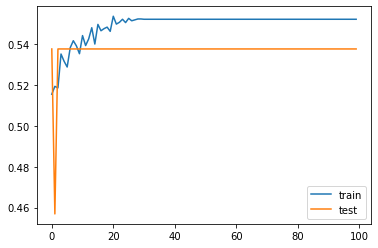

In [49]:
#위에 첫번째와 같은 이미지. 선형으로 그림

plt.plot(history.history['acc'], label="train")
plt.plot(history.history['val_acc'], label="test")

plt.legend()

In [ ]:
# 5개의 컴퓨터에서 kmeanㄴ 클러스터를 돌려 각각 라벨을 가져와 답을 가져온 것은 50% 로도 안넘었는데,
# 그래도 정확도 55%  검사 정확도 52% 는 나왔다. 

# 결론은 학습이 안된거긴 하다
# 원인1:데이터가 부족했거나 (9665 개)
# 원인2: 모델링 설계가 적합하지 않거나
# 원인3: PCA 4개의 값으로만 Hierarchical Clustering (cmplt)4개의 라벨링으로 한게 이상했거나.